In [1]:
# Run in a notebook cell (prefix with !). Install only if you need it.
!pip install xgboost scikit-learn matplotlib pandas joblib
# TensorFlow (optional, heavy). Install only if you want to run LSTM.
# !pip install tensorflow
# reportlab (optional: fallback PDF creation)
# !pip install reportlab


   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   - -------------------------------------- 1.8/56.8 MB 8.4 MB/s eta 0:00:07
   -- ------------------------------------- 2.9/56.8 MB 7.3 MB/s eta 0:00:08
   -- ------------------------------------- 4.2/56.8 MB 6.8 MB/s eta 0:00:08
   --- ------------------------------------ 5.5/56.8 MB 6.6 MB/s eta 0:00:08
   ---- ----------------------------------- 6.8/56.8 MB 6.6 MB/s eta 0:00:08
   ----- ---------------------------------- 8.1/56.8 MB 6.5 MB/s eta 0:00:08
   ------ --------------------------------- 9.4/56.8 MB 6.4 MB/s eta 0:00:08
   ------- -------------------------------- 10.5/56.8 MB 6.4 MB/s eta 0:00:08
   -------- ------------------------------- 11.8/56.8 MB 6.3 MB/s eta 0:00:08
   --------- ------------------------------ 13.1/56.8 MB 6.3 MB/s eta 0:00:07
   ---------- ----------------------------- 14.4/56.8 MB 6.2 MB/s eta 0:00:07
   ----------- ---------------------------- 15.7/56.8 MB 6.3 MB/s eta 0:00:07
 

In [2]:
# Step 1 - imports & config
import os, sys, warnings, pickle
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# optional libraries detection
try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    import tensorflow as tf
    HAS_TF = True
except Exception:
    HAS_TF = False

print("HAS_XGB:", HAS_XGB, "HAS_TF:", HAS_TF)

# Reproducibility
SEED = 42
np.random.seed(SEED)

# Paths
OUTPUT_DIR = Path('outputs')
MODELS_DIR = OUTPUT_DIR / 'models'
OUTPUT_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

# Path to your CSV (set to your file if you have one), otherwise keep None and notebook will generate synthetic data.
DATA_CSV_PATH = None  # e.g. 'data/traffic_hourly.csv'

# Expected minimal columns (if you supply your CSV): timestamp, junction_id, volume


HAS_XGB: True HAS_TF: False


In [3]:
# Step 2 - load data or generate synthetic demo dataset
if DATA_CSV_PATH and Path(DATA_CSV_PATH).exists():
    df = pd.read_csv(DATA_CSV_PATH)
    print("Loaded", DATA_CSV_PATH, "shape=", df.shape)
else:
    print("No CSV provided or file not found. Generating synthetic dataset for demo.")
    rng = pd.date_range(start='2023-01-01', end='2024-12-31 23:00:00', freq='H')
    n = len(rng)
    rows = []
    for jid in [101, 102, 103]:
        base = 200 + 100 * (jid - 100)
        seasonal = 50 * np.sin(2 * np.pi * (np.arange(n) % 24) / 24)
        weekly = 30 * np.where((pd.DatetimeIndex(rng).dayofweek >= 5), -1, 0)
        trend = np.linspace(0, 20, n)
        noise = np.random.normal(0, 20, n)
        volume = np.clip(base + seasonal + weekly + trend + noise, 0, None)
        df_j = pd.DataFrame({
            'timestamp': rng,
            'junction_id': jid,
            'volume': volume
        })
        # example weather / event columns (optional)
        df_j['temperature'] = 20 + 10 * np.sin(2 * np.pi * (pd.DatetimeIndex(rng).dayofyear / 365)) + np.random.normal(0, 2, n)
        df_j['precipitation'] = np.random.choice([0, 0, 0, 1, 2, 5], size=n, p=[0.7, 0.15, 0.05, 0.05, 0.03, 0.02])
        df_j['is_event'] = np.random.binomial(1, 0.01, size=n)
        rows.append(df_j)
    df = pd.concat(rows).reset_index(drop=True)
    print("Synthetic data created, shape=", df.shape)

# Quick look
df.head()


No CSV provided or file not found. Generating synthetic dataset for demo.
Synthetic data created, shape= (52632, 6)


,timestamp,junction_id,volume,temperature,precipitation,is_event
0,2023-01-01 00:00:00,101,279.934283,17.092882,0,0
1,2023-01-01 01:00:00,101,280.176806,17.782767,0,0
2,2023-01-01 02:00:00,101,307.956051,20.259421,0,0
3,2023-01-01 03:00:00,101,335.819356,20.451784,0,0
4,2023-01-01 04:00:00,101,308.622763,24.111447,0,0


In [4]:
# Step 3 - preprocessing & feature engineering
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['junction_id', 'timestamp']).reset_index(drop=True)

# time features
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
df['month'] = df['timestamp'].dt.month

# lag and rolling features per junction
LAGS = [1, 24, 168]          # 1 hour, 1 day, 1 week
ROLL_WINDOWS = [3, 24, 168]  # small window, day, week

def create_lags_and_rolls(g):
    g = g.copy()
    for lag in LAGS:
        g[f'lag_{lag}'] = g['volume'].shift(lag)
    for w in ROLL_WINDOWS:
        g[f'roll_mean_{w}'] = g['volume'].shift(1).rolling(w).mean()
        g[f'roll_std_{w}'] = g['volume'].shift(1).rolling(w).std()
    return g

df = df.groupby('junction_id').apply(create_lags_and_rolls).reset_index(drop=True)

# drop NA introduced by lags/rolls
df = df.dropna().reset_index(drop=True)

# features (exclude timestamp and target)
feature_cols = [c for c in df.columns if c not in ('timestamp', 'volume')]
print("Number of features:", len(feature_cols))
print(feature_cols[:30])


Number of features: 17
['junction_id', 'temperature', 'precipitation', 'is_event', 'hour', 'dayofweek', 'is_weekend', 'month', 'lag_1', 'lag_24', 'lag_168', 'roll_mean_3', 'roll_std_3', 'roll_mean_24', 'roll_std_24', 'roll_mean_168', 'roll_std_168']


In [5]:
# Step 4 - helpers
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def evaluate(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

def plot_predictions(ts, y_true, y_pred, outpath=None, title=None, n_points=200):
    plt.figure(figsize=(14,4))
    plt.plot(ts[:n_points], y_true[:n_points], label='actual')
    plt.plot(ts[:n_points], y_pred[:n_points], label='predicted')
    plt.legend()
    if title:
        plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    if outpath:
        plt.savefig(outpath)
    plt.show()


Junctions: [101 102 103]

=== Processing junction 101 === 
Baseline (lag1) MAE: 24.21611741272632
GBR best params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}
GBR MAE: 16.565918464719385
Training XGBoost for junction 101
XGB MAE: 16.582950317783457


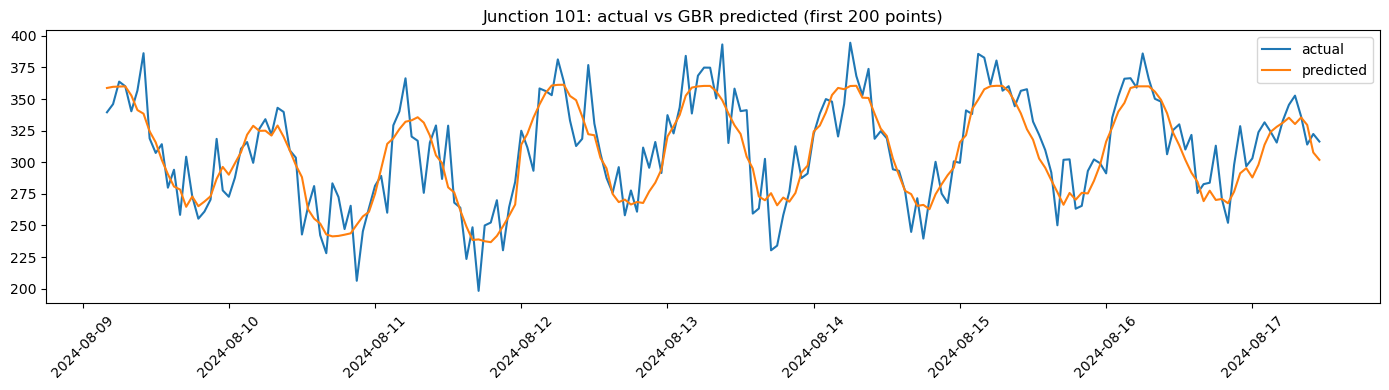

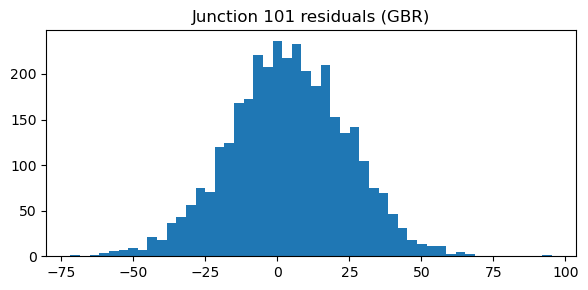

Saved plots to outputs

=== Processing junction 102 === 
Baseline (lag1) MAE: 24.453747211271605


In [ ]:
# Step 5 - train/validation split and model training (per junction)
results = []
junctions = df['junction_id'].unique()
print("Junctions:", junctions)

for jid in junctions:
    print("\n=== Processing junction", jid, "=== ")
    dfj = df[df['junction_id'] == jid].sort_values('timestamp').reset_index(drop=True)

    # time-based holdout: last 20% as validation
    n = len(dfj)
    split_idx = int(n * 0.8)
    train = dfj.iloc[:split_idx]
    val = dfj.iloc[split_idx:]

    X_train = train[feature_cols].drop(columns=['junction_id'], errors='ignore')
    y_train = train['volume']
    X_val = val[feature_cols].drop(columns=['junction_id'], errors='ignore')
    y_val = val['volume']

    # scaling (helpful for some models / LSTM)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    joblib.dump(scaler, MODELS_DIR / f'scaler_j{jid}.pkl')

    # Baseline (naive): last-hour value
    y_pred_naive = val['lag_1'].values
    baseline_metrics = evaluate(y_val, y_pred_naive)
    print("Baseline (lag1) MAE:", baseline_metrics['MAE'])

    # Gradient Boosting (sklearn) with RandomizedSearchCV (time-series CV)
    gbr = GradientBoostingRegressor(random_state=SEED)
    param_dist = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5]
    }
    tscv = TimeSeriesSplit(n_splits=5)
    rnd = RandomizedSearchCV(
        gbr,
        param_distributions=param_dist,
        n_iter=6,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=SEED
    )
    rnd.fit(X_train, y_train)
    best_gbr = rnd.best_estimator_
    print("GBR best params:", rnd.best_params_)

    y_pred_gbr = best_gbr.predict(X_val)
    gbr_metrics = evaluate(y_val, y_pred_gbr)
    print("GBR MAE:", gbr_metrics['MAE'])

    # save model
    joblib.dump(best_gbr, MODELS_DIR / f'gbr_j{jid}.pkl')

    # Optional: XGBoost (if installed)
    if HAS_XGB:
        print("Training XGBoost for junction", jid)
        xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=SEED)
        xparam = {'n_estimators': [100, 300], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
        xrnd = RandomizedSearchCV(xgbr, xparam, n_iter=4, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=SEED)
        xrnd.fit(X_train, y_train)
        best_xgb = xrnd.best_estimator_
        y_pred_xgb = best_xgb.predict(X_val)
        xgb_metrics = evaluate(y_val, y_pred_xgb)
        print("XGB MAE:", xgb_metrics['MAE'])
        joblib.dump(best_xgb, MODELS_DIR / f'xgb_j{jid}.pkl')
    else:
        xgb_metrics = None

    # Save evaluation results & plots
    results.append({
        'junction_id': int(jid),
        'baseline_mae': baseline_metrics['MAE'],
        'gbr_mae': gbr_metrics['MAE'],
        'xgb_mae': xgb_metrics['MAE'] if xgb_metrics else None,
        'gbr_params': rnd.best_params_
    })

    # plots
    plot_predictions(
        val['timestamp'].values,
        y_val.values,
        y_pred_gbr,
        outpath=OUTPUT_DIR / f'plot_j{jid}_preds.png',
        title=f"Junction {jid}: actual vs GBR predicted (first 200 points)"
    )
    resid = y_val.values - y_pred_gbr
    plt.figure(figsize=(6,3))
    plt.hist(resid, bins=50)
    plt.title(f'Junction {jid} residuals (GBR)')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'plot_j{jid}_resid.png')
    plt.show()

    print(f"Saved plots to {OUTPUT_DIR}")


In [ ]:
# Step 6 - Save consolidated evaluation summary
res_df = pd.DataFrame(results).sort_values('junction_id').reset_index(drop=True)
res_df.to_csv(OUTPUT_DIR / 'model_evaluation_summary.csv', index=False)
print("Saved summary CSV to", OUTPUT_DIR / 'model_evaluation_summary.csv')
res_df


In [ ]:
# Step 7 - LSTM example (optional)
if not HAS_TF:
    print("TensorFlow not detected. Skipping LSTM cell.")
else:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    tf.random.set_seed(SEED)

    SEQ_LEN = 24  # use last 24 hours to predict next hour

    def make_sequences(X, y, seq_len=SEQ_LEN):
        Xs, ys = [], []
        for i in range(seq_len, len(X)):
            Xs.append(X[i-seq_len:i])
            ys.append(y.values[i])
        return np.array(Xs), np.array(ys)

    # pick first junction as an example (or loop as above)
    jid = junctions[0]
    dfj = df[df['junction_id'] == jid].sort_values('timestamp').reset_index(drop=True)
    n = len(dfj)
    split_idx = int(n * 0.8)
    train = dfj.iloc[:split_idx]; val = dfj.iloc[split_idx:]

    X_train = train[feature_cols].drop(columns=['junction_id'], errors='ignore')
    y_train = train['volume']
    X_val = val[feature_cols].drop(columns=['junction_id'], errors='ignore')
    y_val = val['volume']

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)

    X_train_seq, y_train_seq = make_sequences(X_train_s, y_train, SEQ_LEN)

    # to build validation sequences, concatenate the last SEQ_LEN rows of train with val
    cat_X = np.vstack([X_train_s[-SEQ_LEN:], X_val_s])
    cat_y = pd.concat([y_train.iloc[-SEQ_LEN:], y_val]).reset_index(drop=True)
    X_val_seq, y_val_seq = make_sequences(cat_X, cat_y, SEQ_LEN)

    print("X_train_seq shape:", X_train_seq.shape, "X_val_seq shape:", X_val_seq.shape)

    model = Sequential([
        LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_seq, y_train_seq, epochs=5, batch_size=64, validation_data=(X_val_seq, y_val_seq))

    y_pred_lstm = model.predict(X_val_seq).flatten()
    print("LSTM MAE:", mean_absolute_error(y_val_seq, y_pred_lstm))

    # save model (HDF5)
    model.save(MODELS_DIR / f'lstm_j{jid}.h5')
    joblib.dump(scaler, MODELS_DIR / f'lstm_scaler_j{jid}.pkl')


In [ ]:
# Step 8 - TimeSeriesSplit cross-validation example (GBR) for one junction
# You can copy/adapt this inside the loop to compute CV metrics on the training period.
from sklearn.base import clone

jid = junctions[0]
dfj = df[df['junction_id'] == jid].sort_values('timestamp').reset_index(drop=True)
n = len(dfj); split_idx = int(n * 0.8)
train = dfj.iloc[:split_idx]
X_train = train[feature_cols].drop(columns=['junction_id'], errors='ignore')
y_train = train['volume']

# Use the best params you found (example: use gbr default or load saved model)
# Load saved GBR for jid if exists:
gbr_path = MODELS_DIR / f'gbr_j{jid}.pkl'
if gbr_path.exists():
    best_model = joblib.load(gbr_path)
else:
    best_model = GradientBoostingRegressor(random_state=SEED)

tscv = TimeSeriesSplit(n_splits=5)
cv_maes = []
for tr_idx, te_idx in tscv.split(X_train):
    X_tr, X_te = X_train.iloc[tr_idx], X_train.iloc[te_idx]
    y_tr, y_te = y_train.iloc[tr_idx], y_train.iloc[te_idx]
    m = clone(best_model)
    m.fit(X_tr, y_tr)
    yp = m.predict(X_te)
    cv_maes.append(mean_absolute_error(y_te, yp))

print("CV MAE mean:", np.mean(cv_maes), "std:", np.std(cv_maes))


In [ ]:
# Step 9 - Write a short report file (plain text)
report = f"""
Traffic Forecasting — Model Evaluation Summary
Author: you

Artifacts produced (in notebook 'outputs' folder):
 - Notebook: copy this .ipynb file
 - Models directory: {MODELS_DIR.resolve()}
 - Model evaluation summary CSV: { (OUTPUT_DIR / 'model_evaluation_summary.csv').resolve() }

Results preview:
{res_df.to_string(index=False)}

Notes:
 - To produce a full PDF with executed outputs, use `jupyter nbconvert --to pdf YourNotebook.ipynb`
 - That command typically requires a LaTeX toolchain on the machine.
"""

with open(OUTPUT_DIR / 'evaluation_report.txt', 'w') as f:
    f.write(report)
print("Saved evaluation_report.txt to", OUTPUT_DIR)
print(report)
